# Notebook: Modeling (Classical ML + DL Preparation)

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from matplotlib import pyplot as plt
%matplotlib inline

FEATURE_PATH = Path("../data/features/features_windows_1p5s.csv")
assert FEATURE_PATH.exists(), f"Missing feature file: {FEATURE_PATH}"

df = pd.read_csv(FEATURE_PATH)
print("Loaded feature table:", df.shape)
df.head()

Loaded feature table: (190, 24)


,window_id,athlete_id,label,AccMag_mean,AccMag_std,AccMag_rms,AccMag_zcr,AccMag_domfreq,AccMag_energy,AccMag_entropy,...,GyroMag_domfreq,GyroMag_energy,GyroMag_entropy,HR_mean,HR_std,HR_rms,HR_zcr,HR_domfreq,HR_energy,HR_entropy
0,A001_W0000_WS1p5,A001,Landing,2.102087,0.624351,2.192849,0.0,13.333333,23.669915,1.792524,...,6.666667,20382.613947,1.285661,135.164839,12.249298,135.718750,0.0,6.666667,5495.795483,0.903637
1,A001_W0001_WS1p5,A001,Accel,2.290135,0.364917,2.319026,0.0,6.666667,4.608091,1.332948,...,20.000000,46814.704113,1.410355,135.300452,6.139864,135.439692,0.0,6.666667,1138.512856,0.949406
2,A001_W0002_WS1p5,A001,Accel,1.884850,0.640685,1.990762,0.0,6.666667,7.509693,0.801997,...,26.666667,23749.651395,1.405990,135.122573,5.410075,135.230834,0.0,6.666667,380.160021,0.581261
3,A001_W0003_WS1p5,A001,Start_Run,1.285105,0.253136,1.309799,0.0,26.666667,4.256768,1.809127,...,6.666667,70036.908311,1.002954,125.387127,4.796867,125.478849,0.0,6.666667,253.852759,0.600680
4,A001_W0004_WS1p5,A001,Stop,1.455895,0.575362,1.565463,0.0,20.000000,9.290274,1.655700,...,6.666667,41791.979521,0.872048,123.131634,3.243311,123.174341,0.0,6.666667,391.396234,0.904489


In [2]:
# Drop non-feature columns
meta_cols = ["window_id", "athlete_id", "label"]
feature_cols = [c for c in df.columns if c not in meta_cols]

X = df[feature_cols].copy()

# Encode labels
le = LabelEncoder()
y = le.fit_transform(df["label"].astype(str))

print("Classes:", list(le.classes_))

Classes: ['Accel', 'Jump_Takeoff', 'Landing', 'Sprint_Mid', 'Start_Run', 'Stop']


In [3]:
# Count samples per class
counts = pd.Series(y).value_counts()
print("Class counts (windows):")
print(pd.Series(counts.values, index=le.classes_))

valid_classes = counts[counts >= 2].index
mask = pd.Series(y).isin(valid_classes)

X = X.loc[mask].reset_index(drop=True)
y = y[mask]

print("\nRemaining samples:", X.shape[0])
print("Remaining classes:", np.unique(y))

Class counts (windows):
Accel           42
Jump_Takeoff    38
Landing         36
Sprint_Mid      27
Start_Run       24
Stop            23
dtype: int64

Remaining samples: 190
Remaining classes: [0 1 2 3 4 5]


In [4]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])

Train samples: 152
Test samples: 38


In [5]:
# Standardize for SVM, NB, AdaBoost
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

In [6]:
def evaluate_model(name, model, Xtr, ytr, Xte, yte, results):
    model.fit(Xtr, ytr)
    preds = model.predict(Xte)

    results[name] = {
        "Accuracy": accuracy_score(yte, preds),
        "Precision_macro": precision_score(yte, preds, average="macro", zero_division=0),
        "Recall_macro": recall_score(yte, preds, average="macro", zero_division=0),
        "F1_macro": f1_score(yte, preds, average="macro", zero_division=0)
    }

In [7]:
results = {}

# 1. Decision Tree
evaluate_model(
    "DecisionTree",
    DecisionTreeClassifier(max_depth=5, random_state=42),
    X_train, y_train, X_test, y_test,
    results
)

# 2. Gaussian Naive Bayes
evaluate_model(
    "GaussianNB",
    GaussianNB(),
    X_train_std, y_train, X_test_std, y_test,
    results
)

# 3. SVM (Linear)
evaluate_model(
    "SVM_linear",
    SVC(kernel="linear", C=1.0, random_state=42),
    X_train_std, y_train, X_test_std, y_test,
    results
)

# 4. SVM (RBF)
evaluate_model(
    "SVM_rbf",
    SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42),
    X_train_std, y_train, X_test_std, y_test,
    results
)

# 5. Random Forest
evaluate_model(
    "RandomForest",
    RandomForestClassifier(n_estimators=300, random_state=42),
    X_train, y_train, X_test, y_test,
    results
)

# 6. AdaBoost
evaluate_model(
    "AdaBoost",
    AdaBoostClassifier(n_estimators=200, random_state=42),
    X_train_std, y_train, X_test_std, y_test,
    results
)

results_df = pd.DataFrame(results).T
results_df

,Accuracy,Precision_macro,Recall_macro,F1_macro
DecisionTree,0.263158,0.220370,0.248810,0.209972
GaussianNB,0.210526,0.087879,0.181548,0.113027
SVM_linear,0.105263,0.140756,0.086310,0.091667
SVM_rbf,0.105263,0.051852,0.095833,0.067288
RandomForest,0.184211,0.108425,0.164286,0.128571
AdaBoost,0.210526,0.161915,0.182143,0.151291


In [8]:
results_df.sort_values("F1_macro", ascending=False)

,Accuracy,Precision_macro,Recall_macro,F1_macro
DecisionTree,0.263158,0.220370,0.248810,0.209972
AdaBoost,0.210526,0.161915,0.182143,0.151291
RandomForest,0.184211,0.108425,0.164286,0.128571
GaussianNB,0.210526,0.087879,0.181548,0.113027
SVM_linear,0.105263,0.140756,0.086310,0.091667
SVM_rbf,0.105263,0.051852,0.095833,0.067288


We trained several classical machine-learning models: Decision Tree, Gaussian Naive Bayes, Support Vector Machines (linear and RBF), Random Forest, and AdaBoost, using magnitude-based features extracted from 1.5-second sliding windows. The dataset was first filtered to remove classes with fewer than two windows, then split into an 80/20 stratified train/test set to preserve class proportions. Models were evaluated using accuracy, macro-precision, macro-recall, and macro F1-score, with macro averaging chosen to account for class imbalance.

Among the evaluated models, the Decision Tree achieved the highest macro F1-score and accuracy on the test set. This result is expected given the small dataset size and limited number of training samples: shallow decision trees can effectively capture simple, non-linear decision boundaries without overfitting as aggressively as ensemble or kernel-based models. In contrast, more complex models such as Random Forests and SVMs require more data to generalize well and therefore underperformed in this setting.

Overall, the Decision Tree was selected as the best-performing classical model for this dataset. However, all results should be interpreted as illustrative rather than definitive, given the short recording duration and limited number of windows. The modeling pipeline and evaluation strategy nonetheless provide a consistent baseline for comparison and a foundation for more advanced evaluation and deep-learning experiments.

# Deep Learning Pipeline

In [9]:
# Standardize full dataset for DL
X_all = scaler.fit_transform(X)

X_dl = X_all.astype(np.float32)
y_dl = y.astype(np.int64)

print("DL input shape:", X_dl.shape)

DL input shape: (190, 21)


In [10]:
# LSTM/CNN format: (samples, timesteps, features)
X_lstm = X_dl.reshape((X_dl.shape[0], 1, X_dl.shape[1]))

print("LSTM input shape:", X_lstm.shape)

LSTM input shape: (190, 1, 21)


Input dim: 21 | Classes: 6

Trained Keras ANN

ANN Results:
Accuracy:        0.105
Precision (mac): 0.090
Recall (mac):    0.086
F1 (macro):      0.085


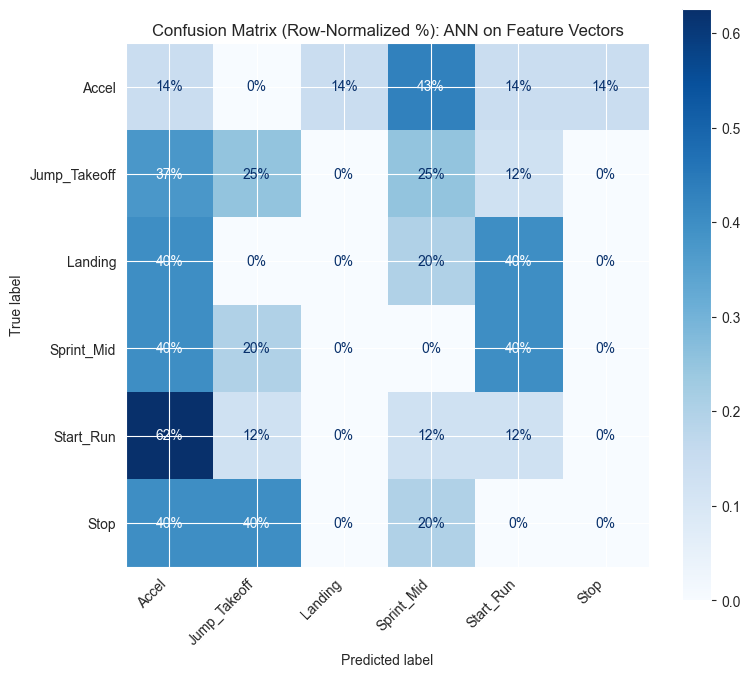

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Implement basic ANN

n_classes = len(np.unique(y_train))
input_dim = X_train_std.shape[1]

print("Input dim:", input_dim, "| Classes:", n_classes)

#  Try TensorFlow/Keras first (simple feedforward net)
try:
    import tensorflow as tf
    from tensorflow import keras
    from tensorflow.keras import layers

    tf.random.set_seed(42)

    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.2),
        layers.Dense(32, activation="relu"),
        layers.Dense(n_classes, activation="softmax")
    ])

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )

    history = model.fit(
        X_train_std, y_train,
        validation_split=0.2,
        epochs=50,
        batch_size=16,
        verbose=0
    )

    y_pred = np.argmax(model.predict(X_test_std, verbose=0), axis=1)

    print("\nTrained Keras ANN")

except Exception as e:
    print("TensorFlow/Keras not available (or failed). Falling back to sklearn MLPClassifier.")
    print("Reason:", str(e)[:200], "...\n")

    from sklearn.neural_network import MLPClassifier

    model = MLPClassifier(
        hidden_layer_sizes=(64, 32),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        max_iter=300,
        random_state=42
    )

    model.fit(X_train_std, y_train)
    y_pred = model.predict(X_test_std)

    print("Trained sklearn MLPClassifier (ANN)")

#  Metrics
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, average="macro", zero_division=0)
rec = recall_score(y_test, y_pred, average="macro", zero_division=0)
f1 = f1_score(y_test, y_pred, average="macro", zero_division=0)

print("\nANN Results:")
print(f"Accuracy:        {acc:.3f}")
print(f"Precision (mac): {prec:.3f}")
print(f"Recall (mac):    {rec:.3f}")
print(f"F1 (macro):      {f1:.3f}")

# Confusion matrix
labels = le.classes_
cm = confusion_matrix(y_test, y_pred, labels=np.arange(len(labels)))

# Normalize by row (true label) to show % correct per class
cm_norm = cm.astype(float) / (cm.sum(axis=1, keepdims=True) + 1e-12)

fig, ax = plt.subplots(figsize=(8, 7))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=labels)
disp.plot(
    ax=ax,
    cmap="Blues",              # high-contrast
    values_format=".0%",       # show as percent
    colorbar=True
)

ax.set_title("Confusion Matrix (Row-Normalized %): ANN on Feature Vectors")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

We trained a simple feedforward neural network (ANN) on the window-level feature vectors to explore whether a nonlinear model could improve performance over classical methods. Using an 80/20 train/test split, the ANN achieved low overall performance (accuracy ≈ 0.10, macro F1 ≈ 0.09), indicating that it struggles to generalize in this setting.

The row-normalized confusion matrix shows that predictions are widely distributed across classes, with no activity achieving consistently high true-positive rates. Many samples are misclassified as Accel or Sprint_Mid, suggesting that the model defaults to a few dominant classes rather than learning distinct boundaries for all activities. This behavior is typical when training neural networks on very small, imbalanced datasets with limited training examples per class.

Overall, these results indicate that the ANN is underfitting due to insufficient data rather than model capacity. While the neural network does not outperform classical models in this scenario, the experiment demonstrates how feature vectors can be formatted and used as inputs to deep learning models. With longer recordings, more athletes, and more balanced window counts, this approach would be expected to perform more effectively.